<center><b><font size=6>Language Models exploration<b><center>

This notebook ...

Experiment language models for solving the same supervised task as in Section 2. In this task, the objective
is to harness the capabilities of language models like Bert or Word2Vec, for supervised learning (assign
intents to sessions).
Two interesting concepts play a role when we use neural networks:
1- it is possible to do transfer learning, i.e., to take a model that have been trained with other
enormous datasets by Big Tech companies, and we can do fine-tuning i.e., to train this model
starting from its pre-trained version.
2- In NLP tasks, words/documents are transformed into vectors (encoding) and this task is
Unsupervised, so we can use a much larger amount of data.
 Choose a language model between Bert and Doc2Vec (word2vec for documents), then:
1. If you choose Doc2Vec: pretrain Doc2Vec on body column of the session text. If you chose Bert: take the pretrained Bert model like in this example. (NB: In this tutorial they used BertForSequenceClassification, but if you want to continue with step 2, you must take an other Bert implementation from HuggingFace)
2. Add a last Dense Layer
3. Fine-tune the last layer of the network on the supervised training set for N epochs.
4. Plot the learning curves on training and validation set. After how many epochs should we stop the training?

<center><b><font size=5>Install Dependencies<b><center>

In [12]:
!python ../scripts/install_dependencies.py section4

Installing common packages: pandas, pyarrow
Installing Section 4 packages: matplotlib, scikit-learn, torch, transformers


<center><b><font size=5>Name<b><center>

In [1]:
import os
import pickle
import time
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertModel, AdamW
import matplotlib.pyplot as plt

In [2]:
# Paths for saving preprocessed data
TOKENIZED_TRAIN_PATH = "../data/processed/train_encodings.pkl"
TOKENIZED_VAL_PATH = "../data/processed/val_encodings.pkl"

# 1. Load Dataset
print("Loading the dataset...")
df = pd.read_parquet("../data/processed/ssh_attacks_sampled_decoded.parquet")
print("Dataset loaded successfully!")
print(f"Dataset size: {df.shape[0]} rows")


Loading the dataset...
Dataset loaded successfully!
Dataset size: 116511 rows


In [3]:
# 2. Preprocess Set_Fingerprint column (multi-label encoding)
print("Preprocessing 'Set_Fingerprint' column...")
df['Set_Fingerprint'] = df['Set_Fingerprint'].apply(lambda x: [intent.strip() for intent in x])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Set_Fingerprint'])
print(f"Classes identified: {mlb.classes_}")

Preprocessing 'Set_Fingerprint' column...
Classes identified: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


In [4]:
# 3. Train-test split
print("Splitting the data into training and validation sets...")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['full_session'], y, test_size=0.2, random_state=42
)
print("Data split complete.")

Splitting the data into training and validation sets...
Data split complete.


In [5]:
# 4. Tokenization with Save/Load Mechanism
print("Loading or performing tokenization...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def save_tokenized_data(filepath, data):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def load_tokenized_data(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Tokenize only if necessary
if os.path.exists(TOKENIZED_TRAIN_PATH) and os.path.exists(TOKENIZED_VAL_PATH):
    print("Loading pre-tokenized data...")
    train_encodings = load_tokenized_data(TOKENIZED_TRAIN_PATH)
    val_encodings = load_tokenized_data(TOKENIZED_VAL_PATH)
else:
    print("Tokenizing data...")
    train_encodings = tokenizer(list(train_texts.fillna("").astype(str)), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(list(val_texts.fillna("").astype(str)), truncation=True, padding=True, max_length=128)
    save_tokenized_data(TOKENIZED_TRAIN_PATH, train_encodings)
    save_tokenized_data(TOKENIZED_VAL_PATH, val_encodings)
    print("Tokenization complete and data saved.")

Loading or performing tokenization...
Loading pre-tokenized data...


In [7]:
# 5. Custom Dataset Class
class SSHDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

    def __len__(self):
        return len(self.labels)


In [8]:
# 6. Prepare DataLoaders
print("Creating DataLoaders...")
train_dataset = SSHDataset(train_encodings, train_labels)
val_dataset = SSHDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=4)
print("DataLoaders are ready.")

Creating DataLoaders...
DataLoaders are ready.


## Addition of the dense layer

In [9]:
# 7. Initialize the Model
print("Initializing the BERT model for sequence classification...")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertModel.from_pretrained('bert-base-uncased')

# Add a custom Dense layer for fine-tuning
class CustomBERTModel(torch.nn.Module):
    def __init__(self, bert_model, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        self.classifier = torch.nn.Linear(bert_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token output
        logits = self.classifier(cls_output)
        return logits

model = CustomBERTModel(model, num_labels=y.shape[1])
model.to(device)

# Disable printing of model architecture
# Removed model printing to clean up logs


Initializing the BERT model for sequence classification...


CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [10]:
# 8. Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

/home/ren/CyberSecurity/ML4N/Project/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Fine tuning of the model

In [11]:
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

# Lists to store metrics for each epoch
tp_rates, fp_rates, tn_rates, fn_rates = [], [], [], []

# Validation
print("Starting the training process...")
for epoch in range(10):  # Fine-tune for 10 epochs
    epoch_start_time = time.time()  # Start timing the epoch
    print(f"Epoch {epoch+1} / 10")
    
    # Training (with progress bar for current epoch)
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}", unit="batch") as pbar:
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputids, attention_mask, labels = (
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['labels'].to(device),
            )
            logits = model(inputids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.update(1)  # Update the progress bar

    train_loss_list.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1} Training loss: {train_loss_list[-1]:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    all_true, all_pred = [], []  # Store all true and predicted values for metric calculation
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Validating Epoch {epoch+1}", unit="batch") as pbar:
            for batch in val_loader:
                input_ids, attention_mask, labels = (
                    batch['input_ids'].to(device),
                    batch['attention_mask'].to(device),
                    batch['labels'].to(device),
                )
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                # Collect predictions and true labels
                all_pred.append(torch.sigmoid(logits).cpu().numpy())  # Apply sigmoid to get probabilities
                all_true.append(labels.cpu().numpy())
                pbar.update(1)  # Update the progress bar
    val_loss_list.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1} Validation loss: {val_loss_list[-1]:.4f}")

    # Compute metrics
    all_true = np.vstack(all_true)
    all_pred = np.vstack(all_pred)
    tp, fp, tn, fn = calculate_metrics(all_true, all_pred)
    tp_rates.append(tp.sum() / all_true.size)
    fp_rates.append(fp.sum() / all_true.size)
    tn_rates.append(tn.sum() / all_true.size)
    fn_rates.append(fn.sum() / all_true.size)
    print(f"Epoch {epoch+1} Metrics - TP: {tp.sum()}, FP: {fp.sum()}, TN: {tn.sum()}, FN: {fn.sum()}")

    # Calculate and print epoch duration and remaining time
    epoch_duration = time.time() - epoch_start_time
    remaining_time = epoch_duration * (10 - (epoch + 1))
    print(f"Epoch {epoch+1} took {epoch_duration:.2f} seconds. Estimated remaining time: {remaining_time:.2f} seconds.")

Starting the training process...
Epoch 1 / 10



raining Epoch 1:   1%|▏                   | 72/5826 [00:15<21:18,  4.50batch/s]

KeyboardInterrupt: 

In [ ]:
# Plot metrics
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), tp_rates, label='True Positive Rate', marker='o')
plt.plot(range(1, 11), fp_rates, label='False Positive Rate', marker='o')
plt.plot(range(1, 11), tn_rates, label='True Negative Rate', marker='o')
plt.plot(range(1, 11), fn_rates, label='False Negative Rate', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.title('Metrics Over Epochs')
plt.legend()
plt.grid()
plt.show()

After how many epochs should we stop the training?

In [71]:
import sys
sys.path.append("../")
from scripts.data_storage_utils import save_plot

In [72]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section4"

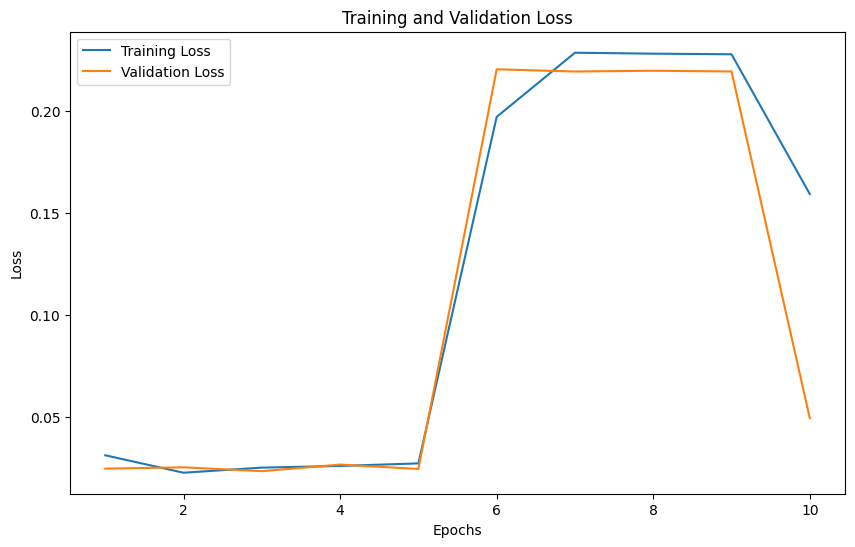

Plot saved successfully at: '../results/figures/plots/section4/training_loss_validation_section4.png'


'../results/figures/plots/section4/training_loss_validation_section4.png'

<Figure size 640x480 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "training_loss_validation_section4", "png", global_overwrite)

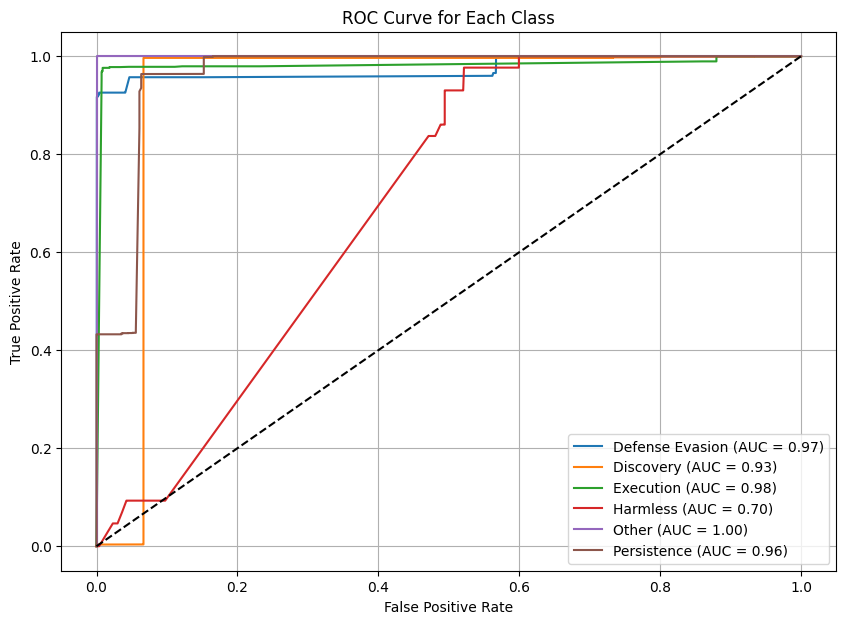

Plot saved successfully at: '../results/figures/plots/section4/ROC_curve_for_class.png'


'../results/figures/plots/section4/ROC_curve_for_class.png'

<Figure size 640x480 with 0 Axes>

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 7))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        # Label each curve with the actual class name
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Assuming `val_labels` and `val_predictions` are available
val_predictions = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities
        val_predictions.append(probs)  # Append predictions for this batch

# Combine all batches into a single array
val_predictions = np.vstack(val_predictions)

# Assuming `mlb.classes_` contains the class names and `val_labels` and `val_predictions` are available
plot_roc_curve(val_labels, val_predictions, mlb.classes_)

current_fig = plt.gcf()
save_plot(current_fig, plot_directory, 'ROC_curve_for_class', "png", global_overwrite)

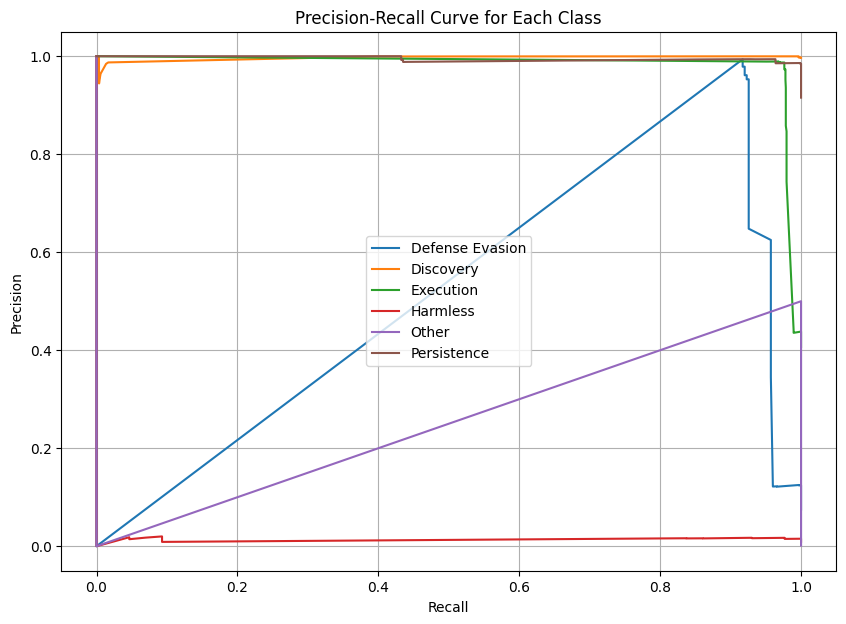

Plot saved successfully at: '../results/figures/plots/section4/precision_recall_per_class.png'


'../results/figures/plots/section4/precision_recall_per_class.png'

<Figure size 640x480 with 0 Axes>

In [76]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 7))
    for i in range(y_true.shape[1]):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Assuming `val_labels` and `val_predictions` are available
plot_precision_recall_curve(val_labels, val_predictions, mlb.classes_)


current_fig = plt.gcf()
save_plot(current_fig, plot_directory, 'precision_recall_per_class', "png", global_overwrite)


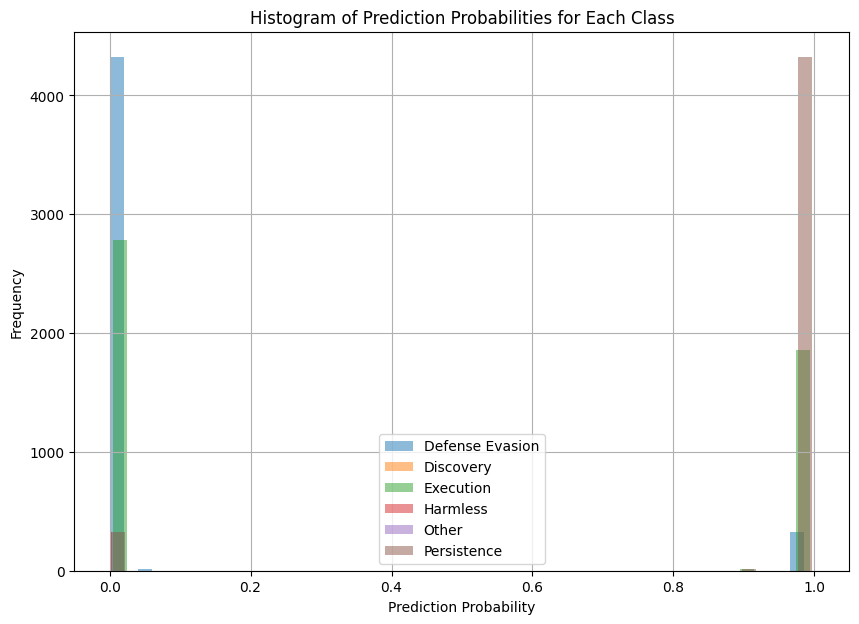

Plot saved successfully at: '../results/figures/plots/section4/hist_for_prediciton_provab_for_class.png'


'../results/figures/plots/section4/hist_for_prediciton_provab_for_class.png'

<Figure size 640x480 with 0 Axes>

In [77]:
def plot_prediction_histogram(y_pred, class_names):
    plt.figure(figsize=(10, 7))
    for i in range(y_pred.shape[1]):
        plt.hist(y_pred[:, i], bins=50, alpha=0.5, label=f'{class_names[i]}')
    
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of Prediction Probabilities for Each Class')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Assuming `val_predictions` are available
plot_prediction_histogram(val_predictions, mlb.classes_)


current_fig = plt.gcf()
save_plot(current_fig, plot_directory, 'hist_for_prediciton_provab_for_class', "png", global_overwrite)

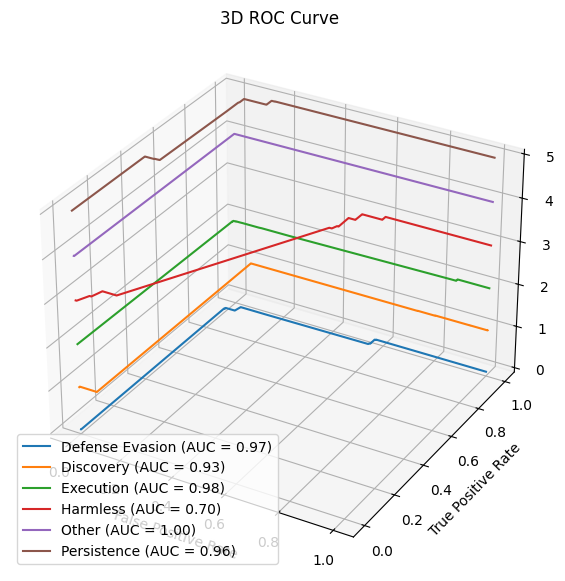

Plot saved successfully at: '../results/figures/plots/section4/3D_ROC_curve_for_class.png'


'../results/figures/plots/section4/3D_ROC_curve_for_class.png'

<Figure size 640x480 with 0 Axes>

In [78]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_roc_curve(y_true, y_pred, class_names):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, zs=i, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_zlabel('Class Index')
    ax.set_title('3D ROC Curve')
    ax.legend(loc='best')
    plt.show()

# Assuming `val_labels` and `val_predictions` are available
plot_3d_roc_curve(val_labels, val_predictions, mlb.classes_)


current_fig = plt.gcf()
save_plot(current_fig, plot_directory, '3D_ROC_curve_for_class', "png", global_overwrite)

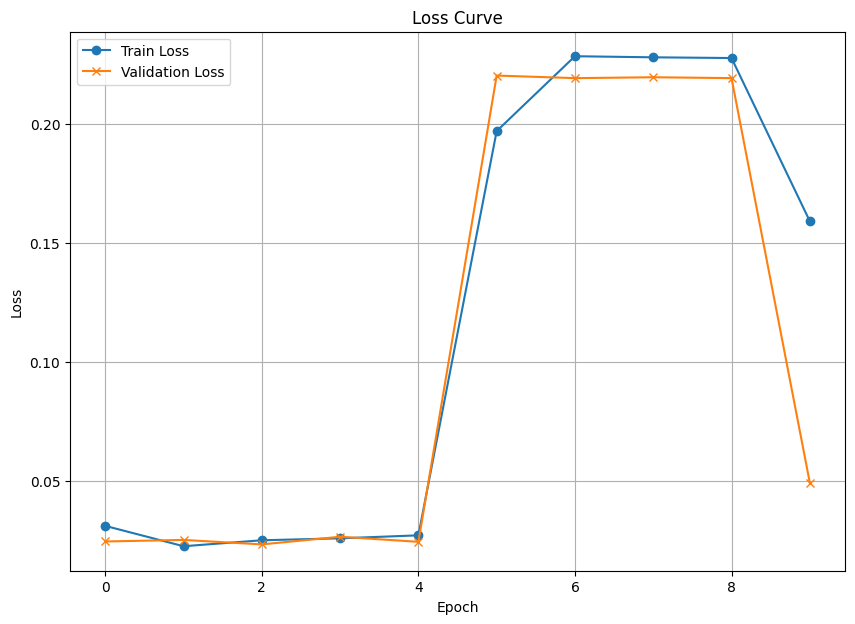

Plot saved successfully at: '../results/figures/plots/section4/better_training_loss_validation_plot.png'


'../results/figures/plots/section4/better_training_loss_validation_plot.png'

<Figure size 640x480 with 0 Axes>

In [79]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 7))

    # Plot losses
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming `train_loss_list` and `val_loss_list` are populated as per your training loop
plot_learning_curve(train_loss_list, val_loss_list)


current_fig = plt.gcf()
save_plot(current_fig, plot_directory, 'better_training_loss_validation_plot', "png", global_overwrite)

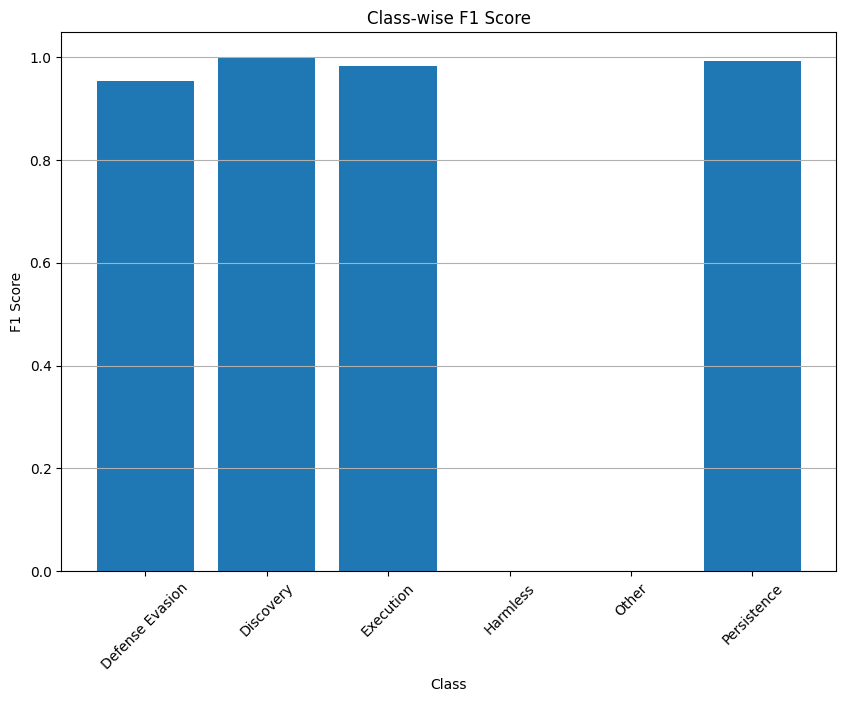

Plot saved successfully at: '../results/figures/plots/section4/flass_wise_F1.png'


'../results/figures/plots/section4/flass_wise_F1.png'

<Figure size 640x480 with 0 Axes>

In [80]:
from sklearn.metrics import f1_score

def plot_classwise_f1_score(y_true, y_pred, class_names):
    f1_scores = f1_score(y_true, (y_pred > 0.5), average=None)
    plt.figure(figsize=(10, 7))
    plt.bar(class_names, f1_scores)
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('Class-wise F1 Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Assuming `val_labels` and `val_predictions` are available
plot_classwise_f1_score(val_labels, val_predictions, mlb.classes_)


current_fig = plt.gcf()
save_plot(current_fig, plot_directory, 'flass_wise_F1', "png", global_overwrite)

/home/ren/CyberSecurity/ML4N/Project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


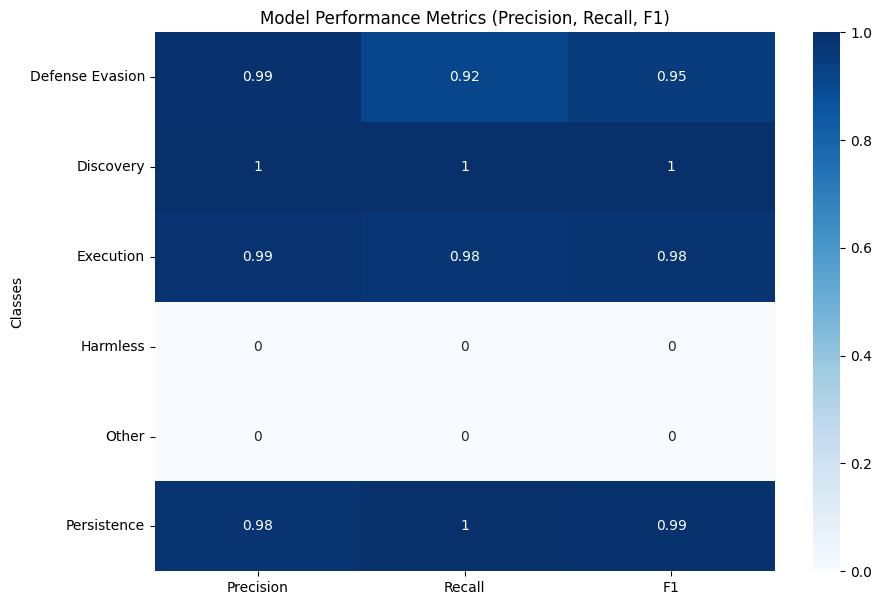

Plot saved successfully at: '../results/figures/plots/section4/model_performance_metrics_precision_recall_F1.png'


'../results/figures/plots/section4/model_performance_metrics_precision_recall_F1.png'

<Figure size 640x480 with 0 Axes>

In [81]:
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_heatmap(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, (y_pred > 0.5), average=None)
    metrics = np.vstack([precision, recall, f1]).T
    plt.figure(figsize=(10, 7))
    sns.heatmap(metrics, annot=True, cmap='Blues', xticklabels=['Precision', 'Recall', 'F1'], yticklabels=class_names)
    plt.title('Model Performance Metrics (Precision, Recall, F1)')
    plt.ylabel('Classes')
    plt.show()

# Assuming `val_labels` and `val_predictions` are available
plot_metrics_heatmap(val_labels, val_predictions, mlb.classes_)


current_fig = plt.gcf()
save_plot(current_fig, plot_directory, 'model_performance_metrics_precision_recall_F1', "png", global_overwrite)